-------------------------------------------------------------------

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

### model 1 

In [65]:
#loading and analysis

In [4]:
train_data_path = "/mypath/was/there/train.csv"
test_data_path = "/mypath/was/there/test.csv"
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

#head to check if loaded
print(train_df.head())
print(test_df.head())

print("\n")

#duplicates search 
duplicates = test_df.duplicated()
num_duplicates = duplicates.sum()
if num_duplicates > 0:
    print(f" {num_duplicates} found in test_df")
    print(test_df[duplicates])
else:
    print("no duplicates in test_df")

duplicates = train_df.duplicated()
num_duplicates = duplicates.sum()
if num_duplicates > 0:
    print(f"{num_duplicates} found in train_df")
    print(train_df[duplicates])
else:
    print("no duplicates in train_df")

print("\n")
print(f"Num of records in train before preprocessing {train_df.shape[0]}")
print(f"Num of records in test before preprocessing {test_df.shape[0]}")

print("\n")
# nans search
print("missing values in train_df")
print(train_df.isnull().sum())
print("\n")
print("missing values in test_df")
print(test_df.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [67]:
#preprocessing

In [68]:
# filling nans
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# dropping cabin, too many nans
train_df.drop(columns=['Cabin'], inplace=True)
test_df.drop(columns=['Cabin'], inplace=True)

# categorical to numerical conversion, required for regression problems
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

train_df['Embarked'] = train_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test_df['Embarked'] = test_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})


print(f"Num of records in train before preprocessing {train_df.shape[0]}")
print(f"Num of records in train before preprocessing {test_df.shape[0]}")

print("\n")
print("Train after preprocessing")
print(train_df.head())
print("\nTest after preprocessing")
print(test_df.head())

# joining features 
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df['IsAlone'] = 1  # if FamilySize is 1 the passenger is alone
train_df.loc[train_df['FamilySize'] > 1, 'IsAlone'] = 0  # set to 0 if FamilySize greater than 1
test_df['IsAlone'] = 1
test_df.loc[test_df['FamilySize'] > 1, 'IsAlone'] = 0

# extracting titles from names
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# replacing rare titles with rare and standarizing
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

# categorical to numerical conversion, required for regression problems
train_df['Title'] = train_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
train_df['Title'] = train_df['Title'].fillna(0)
test_df['Title'] = test_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
test_df['Title'] = test_df['Title'].fillna(0)


Num of records in train before preprocessing 891
Num of records in train before preprocessing 418


Train after preprocessing
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  Embarked  
0         A/5 21171   7.2500         2  
1          PC 17599  71.2833         0  
2  STON/O2. 3101282   7.9250         2  
3     

In [69]:
#creating and training the model

In [70]:
# selecting features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
X = train_df[features]
y = train_df['Survived']
test_X = test_df[features]

# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# initialization of random forest model and training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [71]:
#the metrics

Validation accuracy 0.84
Cross-entropy loss 0.58
ROC AUC 0.90
Confusion matrix
[[91 14]
 [15 59]]
Precision 0.81
Recall 0.80
F1 score 0.80


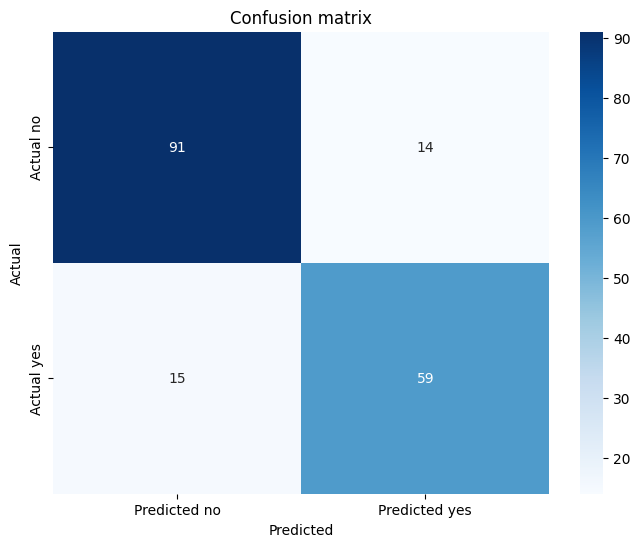

In [72]:
# validation and cross-entropy loss
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)

accuracy = accuracy_score(y_val, y_pred)
logloss = log_loss(y_val, y_pred_proba)

print(f"Validation accuracy {accuracy:.2f}")
print(f"Cross-entropy loss {logloss:.2f}")

# roc_auc, confusion matrix, precision, recall, f1
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])
conf_matrix = confusion_matrix(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"ROC AUC {roc_auc:.2f}")
print(f"Confusion matrix\n{conf_matrix}")
print(f"Precision {precision:.2f}")
print(f"Recall {recall:.2f}")
print(f"F1 score {f1:.2f}")

# matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted no', 'Predicted yes'], yticklabels=['Actual no', 'Actual yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()


### model 2

In [73]:
#creating and training with grid search

In [75]:
# parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

# initialization of random forest model 
rf_model = RandomForestClassifier(random_state=42)

# initialization of grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fitting 
grid_search.fit(X_train, y_train)

# best params and score according to grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best params {best_params}")
print(f"Best cross-val score {best_score:.2f}")

# using best model for predictions and validation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)
accuracy_best = accuracy_score(y_val, y_pred_best)
print(f"Validation accuracy- best model {accuracy_best:.2f}")


Best params {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 300}
Best cross-val score 0.83
Validation accuracy- best model 0.82


In [ ]:
#the metrics

ROC AUC 0.90
Confusion matrix
[[92 13]
 [19 55]]
Cross-entropy loss 0.40
Precision 0.81
Recall 0.74
F1 score 0.77


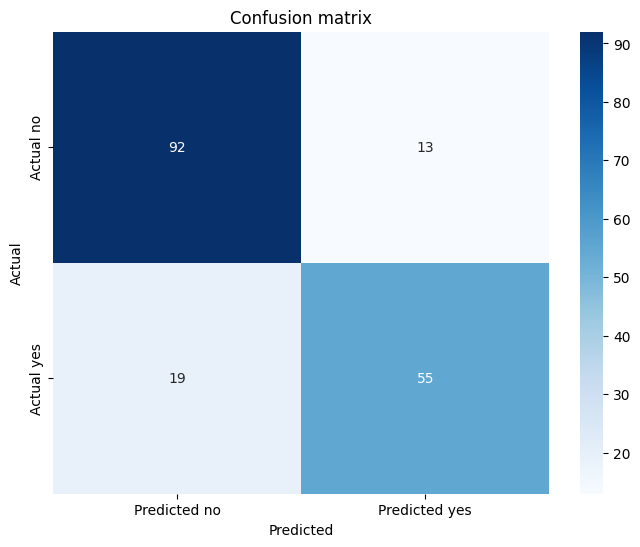

In [76]:
y_pred_best_proba = best_model.predict_proba(X_val)

# roc_auc, confusion matrix, precision, recall, f1, cross entropy loss
cross_entropy_loss = log_loss(y_val, y_pred_best_proba)
roc_auc = roc_auc_score(y_val, y_pred_best_proba[:, 1])
conf_matrix = confusion_matrix(y_val, y_pred_best)
precision = precision_score(y_val, y_pred_best)
recall = recall_score(y_val, y_pred_best)
f1 = f1_score(y_val, y_pred_best)

print(f"ROC AUC {roc_auc:.2f}")
print(f"Confusion matrix\n{conf_matrix}")
print(f"Cross-entropy loss {cross_entropy_loss:.2f}")
print(f"Precision {precision:.2f}")
print(f"Recall {recall:.2f}")
print(f"F1 score {f1:.2f}")

# matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted no', 'Predicted yes'], yticklabels=['Actual no', 'Actual yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()


#### Better model for predicting if the person is a survivor is a model number 1, it has better scores than model 2 scores except cross-entropy loss, which is slightly higher